In [1]:
from fastai.vision.all import *
from fastai.vision.widgets import *
from fastai.callback.fp16 import *
import torchvision.models as models

import warnings
warnings.filterwarnings('ignore')

In [2]:
path_imgs = Path('X Ray Images')

In [3]:
dls = ImageDataLoaders.from_csv(path_imgs
                                ,'labels.csv'
                                ,folder='images'
                                ,label_delim='|'
                                ,item_tfms=Resize(224)
                                ,num_workers=0
                                ,bs=64)

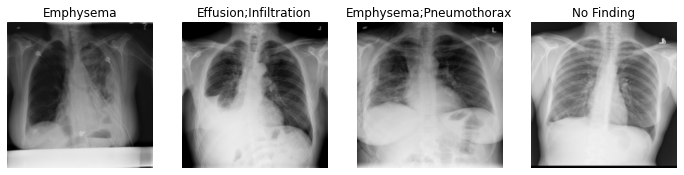

In [4]:
dls.valid.show_batch(max_n=4, nrows=1)

In [5]:
learn = cnn_learner(dls, models.mobilenet_v2, cut=-1, metrics=partial(accuracy_multi, thresh=0.5))

In [6]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.956460,0.738644,0.565031,02:34
1,0.672849,0.370537,0.897116,01:58
2,0.419131,0.245213,0.927624,01:56
3,0.311819,0.237166,0.926851,01:59


In [7]:
pred,pred_idx,probs = learn.predict('X Ray Images/images/00000017_001.png')
print(pred, pred_idx, probs)

['No Finding'] tensor([False, False, False, False, False, False, False, False, False, False,
         True, False, False, False, False]) tensor([0.1676, 0.1044, 0.1166, 0.1222, 0.1236, 0.0342, 0.0680, 0.0871, 0.1343,
        0.1022, 0.6510, 0.1510, 0.1220, 0.0765, 0.0374])


In [8]:
learn.path = Path('.')

In [9]:
learn.export(fname='x_ray_fastai_mobilenet_v2.pkl')

In [10]:
learn_inf = load_learner('x_ray_fastai_mobilenet_v2.pkl')

In [11]:
learn_inf.dls.transform

PILBase.create:
encodes: (Path,object) -> create
(str,object) -> create
(Tensor,object) -> create
(ndarray,object) -> create
(bytes,object) -> createdecodes: 

In [12]:
labels = learn_inf.dls.vocab
labels

['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']

In [13]:
import torch
import torchvision
import torchvision.transforms as transforms

pytorch_model = learn_inf.model.eval()
sigmoid_layer = torch.nn.Sigmoid()

final_model = nn.Sequential(
    pytorch_model
    ,sigmoid_layer
)

In [15]:
torch.onnx.export(
    final_model, 
    torch.randn(1, 3, 224, 224, requires_grad=False),
    "x_ray_fastai_mobilenet_v2.onnx",
    export_params=True,
    input_names=["input"],
    output_names=["output"]
)

In [16]:
import onnx

# Load the ONNX model
model = onnx.load('x_ray_fastai_mobilenet_v2.onnx')

# Check that the IR is well formed
onnx.checker.check_model(model)

# Print a human readable representation of the graph
#onnx.helper.printable_graph(model.graph)

In [17]:
import numpy as np
import onnxruntime as rt

np.set_printoptions(suppress=True)

In [18]:
from PIL import Image

def image_transform_onnx(path: str, size: int) -> np.ndarray:
    '''Image transform helper for onnx runtime inference.'''

    image = Image.open(path)
    image = image.resize((size,size))
    image = image.convert('RGB')
    print(image.shape, image.mode)


    # now our image is represented by 3 layers - Red, Green, Blue
    # each layer has a 224 x 224 values representing
    image = np.array(image)
    print('Conversion to tensor: ',image.shape)

    # dummy input for the model at export - torch.randn(1, 3, 224, 224)
    image = image.transpose(2,0,1).astype(np.float32)
    print('Transposing the tensor: ',image.shape)

    # our image is currently represented by values ranging between 0-255
    # we need to convert these values to 0.0-1.0 - those are the values that are expected by our model

    print('Integer value: ', image[0][0][40])
    image /= 255
    print('Float value: ', image[0][0][40])

    # expanding the alread existing tensor with the final dimension (similar to unsqueeze(0))
    # currently our tensor only has rank of 3 which needs to be expanded to 4 - torch.randn(1, 3, 224, 224)
    # 1 can be considered the batch size

    image = image[None, ...]
    print('Final shape of our tensor', image.shape, '\n')
    return image

In [19]:
img_tensor_onnx = image_transform_onnx('X Ray Images/images/00000032_001.png', 224)

(224, 224) RGB
Conversion to tensor:  (224, 224, 3)
Transposing the tensor:  (3, 224, 224)
Integer value:  3.0
Float value:  0.011764706
Final shape of our tensor (1, 3, 224, 224) 



In [20]:
# initialize onnx runtime inference session
sess = rt.InferenceSession('x_ray_fastai_mobilenet_v2.onnx')

# input & output names
input_name = sess.get_inputs()[0].name
output_name = sess.get_outputs()[0].name

# input dimensions
input_dims = sess.get_inputs()[0].shape

input_name, output_name, input_dims

('input', 'output', [1, 3, 224, 224])

In [21]:
results = sess.run([output_name], {input_name: img_tensor_onnx})[0]
labels[np.argmax(results)], results, labels

('Edema',
 array([[0.08862952, 0.11452571, 0.04559455, 0.14546575, 0.09492613,
         0.03178429, 0.03082022, 0.01584386, 0.13190447, 0.0805859 ,
         0.08089215, 0.04370015, 0.04050881, 0.03082181, 0.02399676]],
       dtype=float32),
 ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'])